In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from src.geo import *
from src.stations import Stations
from src.track import Track, TrackCollection

from tqdm import tqdm
import json

%matplotlib inline

In [3]:
## Load test data
test = (pd.read_csv('data/round2_competition.csv')
          .assign(test = lambda x: x.latitude.apply(lambda y: int(np.isnan(y))))
          .loc[lambda x: x.test==1]
          .reset_index(drop=True)
        )

In [4]:
# Download stations parameters calculated previously

with open('stations_params.json', 'r') as f:
    st_params = json.load(f)

# A0 and B values from optimization of 35 good stations
A0_B = [pow(10, y) for y in [-3.43667365e+00, -4.06472353e+00]]
    
st = Stations([int(s) for s in st_params])
st.A0 = A0_B[0]
st.B = A0_B[1]
print('Number of synchronized stations=', len(st.inventory))

for s in st_params:
    st.update_location(int(s), st_params[s]['location'])

st.st_params = st_params

Number of synchronized stations= 241


### Transform data to collection of tracks <u>with time correction</u>

In [5]:
test_tracks = TrackCollection(test, st)

100%|██████████| 300/300 [00:51<00:00,  5.87it/s]


## Predict tracks

In [6]:
from scipy.optimize import fmin_l_bfgs_b
from sklearn.cluster import DBSCAN

from src.filters import filter_speedlimit
from optimize import solve_point
from src.track import check_point

import gc


def predict_track(track, filename, verbose=False):
    tel = (track._telemetry
           .assign(num = lambda x: x.stations.apply(lambda y: len(y)))
           .assign(times = lambda x: x.times.apply(lambda y: np.array(y)))
            )
    stations = track._st
        
    # stations locations in cartesian coordinates
    st_cart = []
    # stations heights
    st_hgt = []
        
    for s in stations.inventory:
        st_cart += stations.carts(s)
        st_hgt += [stations.locs(s)[2]]
        
    # save as np.array
    st_cart = np.array(st_cart)
    st_hgt = np.array(st_hgt)
        
    N = tel.shape[0]
        
    y = tel[['latitude', 'longitude', 'baroAltitude', 'geoAltitude']].values
    all_times = tel.times.values
    all_stations = tel.stations.values
    
    # arrays to save results
    lat_pred, lon_pred, err = np.zeros(N), np.zeros(N), np.zeros(N)
        
    ### Solve multilateration equations
    # all points having 3 or more measurements
    for i in tel[tel.num >= 3].index:
        sts = all_stations[i]

        # estimate initial aircraft position as barocentric for given stations
        x0 = np.zeros(2)
        for s in sts:
            x0 += np.array(stations.locs(s)[:2])

        x0 /= len(sts)

        # optimization using solve_point function from optimization package
        result = fmin_l_bfgs_b(solve_point, x0,
                               args=(y[i, 2],
                                     all_times[i],
                                     np.array([stations.i(s) for s in sts], dtype=np.int32),
                                     st_cart,
                                     st_hgt,
                                     stations.A0,
                                     stations.B,
                                     1),
                               factr=10,
                               approx_grad=1
                               )
            
        lat_pred[i] = result[0][0]
        lon_pred[i] = result[0][1]
        err[i] = result[1]
            
    # save results to dataframe
    tel['lat_pred'] = lat_pred
    tel['lon_pred'] = lon_pred
    tel['err'] = err
    
    del st_cart, st_hgt, y, all_times, all_stations, lat_pred, lon_pred, err
    
    # filter points which haven't been calculated
    ind = np.where(tel.err.values > 0)[0]
    if len(ind) == 0:
        return pd.DataFrame()

    # apply simple DBSCAN filter to filter out detached points
    db = DBSCAN(eps=0.02, min_samples=4).fit(tel[['lon_pred', 'lat_pred']].values[ind])
    ind2 = ind[np.where(db.labels_!=-1)[0]]
    
    del db
        
    if len(ind2) == 0:
        return pd.DataFrame()
        
    # Filter by graph model
    res = filter_speedlimit(tel.lat_pred.values[ind2],
                            tel.lon_pred.values[ind2],
                            tel.timeAtServer.values[ind2],
                            0, 300, verbose)
    ind3 = ind2[np.where(res == True)[0]]
    
    del ind, ind2, res
        
    if len(ind3) == 0:
        return pd.DataFrame()
    
    # only filtered points
    part = tel.iloc[ind3]
    # all track points
    tel['lat_pred2'] = np.zeros(N)
    tel['lon_pred2'] = np.zeros(N)
    
    # interpolate track points around predicted locations
    i = 0
    while i < part.shape[0]:
        try:  # sometimes HuberRegression doesn't converge
            id_max = check_point(tel, part, part.timeAtServer.values[i], Teps=30, Nmin=10, ds_max=35)
        except:
            # return unsuccess
            id_max = -1

        if id_max == -1:
            # unsuccess -> move to the next point in part
            i += 1
        else:
            # success -> move to the next point outside the neighborhood
            i = np.where(part.id.values == id_max)[0][0] + 1
                
    del part

    # filter out predicted points
    indx = np.where(tel.lat_pred2.values != 0)[0]
    if len(indx) == 0:
        return pd.DataFrame()
        
    # save result
    x = tel.iloc[indx]
    x[['id', 'lat_pred2', 'lon_pred2', 'lat_pred', 'lon_pred']].to_csv(filename, mode='a', header=False, index=False)
    
    del tel, x
    gc.collect()
    return


In [21]:
for track in tqdm(test_tracks):
    predict_track(track, 'predictions_test.csv')

100%|██████████| 300/300 [3:08:10<00:00, 37.63s/it]   


### Check that prediction has at least 70% of the test dataset
#### (Prediction accuracy should be about 85m on the public leaderboard if submitted)

In [7]:
print('Prediction size =', pd.read_csv('predictions_test.csv').shape[0] / test.shape[0]) 

Prediction size = 0.7179554833694615


In [8]:
# Prepare submission

submission_filename = 'submission_raw.csv'

(pd.read_csv('predictions_test.csv',
             names=['id', 'lat_pred2', 'lon_pred2', 'lat_pred', 'lon_pred'])
    .loc[lambda x: (~np.isnan(x.lat_pred2))&(x.lat_pred2>0)]
    .merge(test, on='id', how='outer')
    .loc[:, ['id', 'lat_pred2', 'lon_pred2', 'baroAltitude']]
    .rename(columns={'lat_pred2':'latitude',
                         'lon_pred2':'longitude',
                         'baroAltitude':'geoAltitude'})
    .sort_values('id', ascending=True)
    .to_csv(submission_filename, index=False)
)

## Filter tracks

The idea here is to fit splines for latitude and longitude as functions of timeAtServer for each track. Distance between predicted points and splines will give an estimation of error in points.

In order to improve accuracy further, we can fill in gaps between prediction points. The more points we add, the more ones we can remove using the approch above. I found that accuracy of added points depends on gap duration. In competition the best result on the public leaderboard showed adding gaps of 60s or less.

In [9]:
# Load prediction points

pred = (pd.read_csv('predictions_test.csv',
                    names=['id', 'lat_pred2', 'lon_pred2', 'lat_pred', 'lon_pred'])
        .merge(test, on='id', how='outer')
       )

In [10]:
from scipy.interpolate import splrep, splev

cols = ['id', 'lat_pred2', 'lon_pred2', 'lat_pred', 'lon_pred']

def filter_spline(aircraft, filename, rm_threshold, add_threshold):

    tel = pred[pred.aircraft == aircraft].sort_values('timeAtServer', ascending=True).reset_index(drop=True)
    
    # error between raw predictions and smoothed
    tel = tel.assign(err_pred = lambda x: [haversine_distance(lat1, lon1, lat2, lon2) for lat1, lon1, lat2, lon2 in zip(x.lat_pred,
                                                                                                                  x.lon_pred,
                                                                                                                  x.lat_pred2,
                                                                                                                  x.lon_pred2)])

    # points where pred_error < 50m
    ind_50 = np.where(~np.isnan(tel.lon_pred2.values) & (tel.lon_pred2.values!=0) & (tel.err_pred < 50))[0]
    # points with predictions
    ind2 = np.where((~np.isnan(tel.lon_pred2.values)) & (tel.lon_pred2.values!=0))[0]

    # fit splines
    spl_lon = (np.array([]), np.array([np.nan]), 5)
    spl_lat = (np.array([]), np.array([np.nan]), 5)

    # find the lowest smooth parameter for a track
    s = 1e-5
    while any(np.isnan(spl_lon[1])) or any(np.isnan(spl_lat[1])):
        try:
            spl_lon = splrep(tel.timeAtServer.values[ind_50],
                             tel.lon_pred2.values[ind_50],
                             s=s, k=5)

            spl_lat = splrep(tel.timeAtServer.values[ind_50],
                             tel.lat_pred2.values[ind_50],
                             s=s, k=5)
        except:
            return
        
        if s > 1e-3:
            # return without points
            return
        
        s += 1e-5


    ### Remove points with large estimated error between predicted points and splines
    err_dist = [haversine_distance(lat1, lon1, lat2, lon2) for lat1, lon1, lat2, lon2 in zip(tel.lat_pred2.values[ind2],
                                                                                  tel.lon_pred2.values[ind2],
                                                                                  splev(tel.timeAtServer.values[ind2], spl_lat),
                                                                                  splev(tel.timeAtServer.values[ind2], spl_lon))]
    
    ind_final = ind2[np.where(np.array(err_dist) < rm_threshold)[0]]
    
    # find gaps
    if len(np.where(np.diff(tel.timeAtServer.values[ind2]) > 15)[0]) > 0:
        ind_gaps = (ind2[np.concatenate([np.array([i, i+1]) for i in np.where(np.diff(tel.timeAtServer.values[ind2]) > 15)[0]])]).tolist()
        ind_add = []
        
        for i in range(0, len(ind_gaps), 2):
            # add points if gap less than add_threshold
            if tel.timeAtServer.values[ind_gaps[i+1]] - tel.timeAtServer.values[ind_gaps[i]] < add_threshold:
                tel.loc[ind_gaps[i]+1:ind_gaps[i+1]-1, 'lat_pred2'] = splev(tel.timeAtServer.values[ind_gaps[i]+1:ind_gaps[i+1]], spl_lat)
                tel.loc[ind_gaps[i]+1:ind_gaps[i+1]-1, 'lon_pred2'] = splev(tel.timeAtServer.values[ind_gaps[i]+1:ind_gaps[i+1]], spl_lon)
                ind_add += list(np.arange(ind_gaps[i]+1, ind_gaps[i+1]))
                
        ind_final = np.sort(np.r_[ind_final, np.array(ind_add)])

    # save resulls
    tel.loc[ind_final, cols].to_csv(filename, mode='a', header=False, index=False)
    return
    

In [12]:
## Find optimal rm_threshold value for a given add_threshold filter,
## so that to get prediction of 70% of test points 

lb, rb = 50, 500

# converge when rm_threshold is between lb and rb
while rb - lb > 1:
    #print(lb, rb)
    
    # remove previous estimation
    !rm submission_filtered.csv
    
    # filter points
    for a in pred.aircraft.unique():
        filter_spline(a, 'submission_filtered.csv', 0.5*(lb+rb), 60)
        
    # assign new lb or rb
    if pd.read_csv('submission_filtered.csv').shape[0] / test.shape[0] > 0.7:
        rb = 0.5*(lb+rb)
    else:
        lb = 0.5*(lb+rb)
        
if pd.read_csv('submission_filtered.csv').shape[0] / test.shape[0] < 0.7:
    !rm submission_filtered.csv
    for a in pred.aircraft.unique():
        filter_spline(a, 'submission_filtered.csv', rb, 60)
    
print('Prediction size =', pd.read_csv('submission_filtered.csv').shape[0] / test.shape[0] )

rm: cannot remove 'submission_filtered.csv': No such file or directory
Prediction size = 0.7000167474547029


In [13]:
r = pd.read_csv('submission_filtered.csv', names=['id', 'lat_pred2', 'lon_pred2', 'lat_pred', 'lon_pred'])

#len(r.id.unique()) / test.shape[0]
(r.merge(test, on='id', how='outer')
  .sort_values('id', ascending=True)
  .loc[:, ['id', 'lat_pred2', 'lon_pred2', 'baroAltitude']]
  .rename(columns={'lat_pred2':'latitude',
                   'lon_pred2':'longitude',
                   'baroAltitude':'geoAltitude'})
).to_csv('submission_filtered.csv', index=False)

## Explore predictions

In [14]:
r = (pd.read_csv('submission_filtered.csv')
     .merge(test[['id', 'aircraft']], on='id', how='outer')
    )

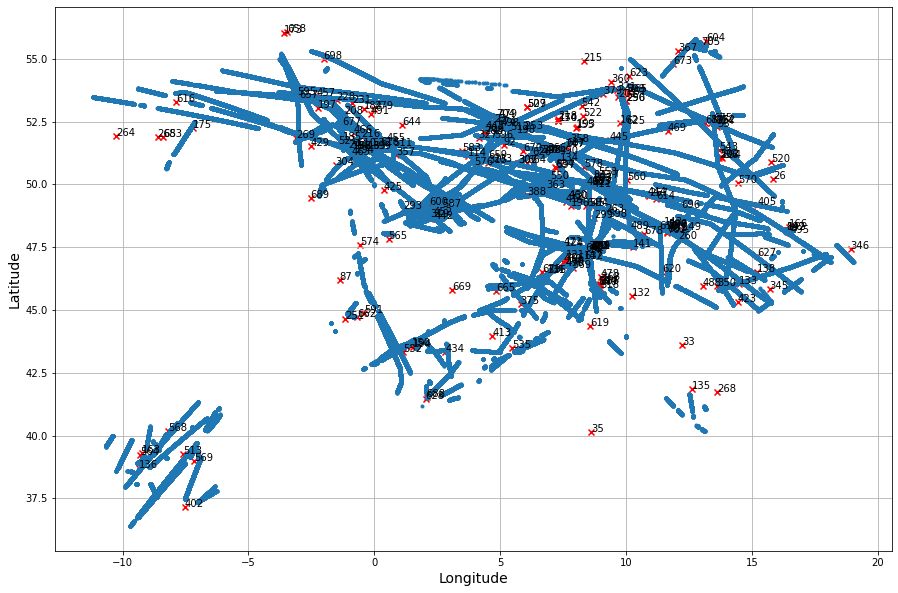

In [15]:
figsize(15, 10)
st.plot()
plt.plot(r.longitude, r.latitude, '.')